# Requirements

In [1]:
# Add as many imports as you need.
from datasets import load_dataset, Dataset, DatasetDict

D:\anaconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of Spotify user reviews. The dataset contains two attributes:

+ **review** - A text column containing user feedback, opinions, and experiences with the Spotify application.
+ **sentiment** - A categorical column indicating whether the review has a positive or negative sentiment.

Your task involves training a model to predict the **sentiment** (either "positive" or "negative") based on the content of the **review**.

## The Spotify User Reviews Dataset

Load the dataset using the `datasets` library.

In [2]:
# Write your code here. Add as many boxes as you need.
from datasets import load_dataset

dataset = load_dataset("csv", data_files="data/spotify-user-reviews.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})

In [3]:
df = dataset["train"].to_pandas()
df["label"].unique()

array(['positive', 'negative'], dtype=object)

In [4]:
df = df.head(1000)
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
995,Songs are great but after a while the audio st...,negative
996,It's a great app but you can't listen to one s...,negative
997,Uh Where's the button to play songs when addin...,negative
998,Updating review: The latest update has changed...,negative


In [5]:
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(df)
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 1000
    })
})

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["label"])

In [7]:
dataset['train'] = dataset['train'].remove_columns("label")
dataset["train"] = dataset["train"].add_column("label", labels)
dataset = dataset.rename_column("review", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [8]:
# Write your code here. Add as many boxes as you need.
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [9]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoTokenizer
checkpoint = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [11]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9535.87 examples/s]


## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [12]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [17]:
# Write your code here. Add as many boxes as you need.
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    # report_to="none",
)

In [18]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

Define the training using the `Trainer` class.

In [21]:
# Write your code here. Add as many boxes as you need.
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Fine-tune (train) the pre-trained lanugage model.

In [22]:
# Write your code here. Add as many boxes as you need.
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.275632,0.910027


TrainOutput(global_step=50, training_loss=0.366387825012207, metrics={'train_runtime': 362.2702, 'train_samples_per_second': 2.208, 'train_steps_per_second': 0.138, 'total_flos': 42105991078080.0, 'train_loss': 0.366387825012207, 'epoch': 1.0})

In [23]:
trainer.evaluate()

{'eval_loss': 0.2756316661834717,
 'eval_f1': 0.9100270243218899,
 'eval_runtime': 23.0233,
 'eval_samples_per_second': 8.687,
 'eval_steps_per_second': 0.565,
 'epoch': 1.0}

Use the trained model to make predictions for the test set.

In [24]:
# Write your code here. Add as many boxes as you need.
predictions = trainer.predict(tokenized_dataset["test"])

In [25]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [26]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        96
           1       0.92      0.90      0.91       104

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



Text(0.5, 1.0, 'Confusion Matrix')

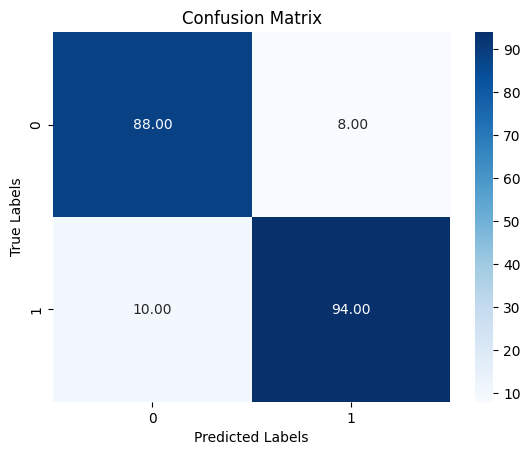

In [27]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a machine learning pipeline to classify Spotify user reviews as positive or negative. Use TF-IDF vectorization to transform the review text into numerical features, and train a logistic regression model on the transformed data. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. To gain insights into the most influential words or phrases associated with positive and negative reviews, analyze the coefficients from the logistic regression model trained on the TF-IDF features. Present the top keywords for each sentiment in a table or a bar chart to provide a clear understanding of the terms driving user feedback.

In [28]:
# Write your code here. Add as many boxes as you need.
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
995,Songs are great but after a while the audio st...,negative
996,It's a great app but you can't listen to one s...,negative
997,Uh Where's the button to play songs when addin...,negative
998,Updating review: The latest update has changed...,negative


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(df['review'],  df['label'], test_size=0.2)     

In [42]:
model = make_pipeline_imb(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, Y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [43]:
y_pred = model.predict(X_test)

In [44]:
print(classification_report_imbalanced(Y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

   negative       0.83      0.90      0.83      0.86      0.86      0.75        96
   positive       0.90      0.83      0.90      0.86      0.86      0.74       104

avg / total       0.86      0.86      0.86      0.86      0.86      0.74       200



# Невронска мрежа

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [46]:
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
995,Songs are great but after a while the audio st...,negative
996,It's a great app but you can't listen to one s...,negative
997,Uh Where's the button to play songs when addin...,negative
998,Updating review: The latest update has changed...,negative


<Axes: xlabel='label'>

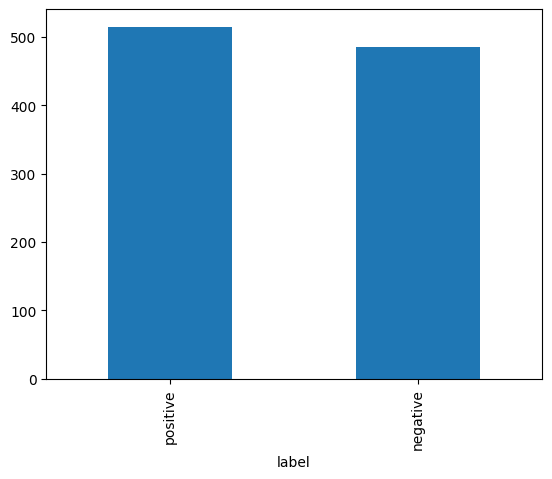

In [47]:
df["label"].value_counts().plot.bar()

<Axes: ylabel='Frequency'>

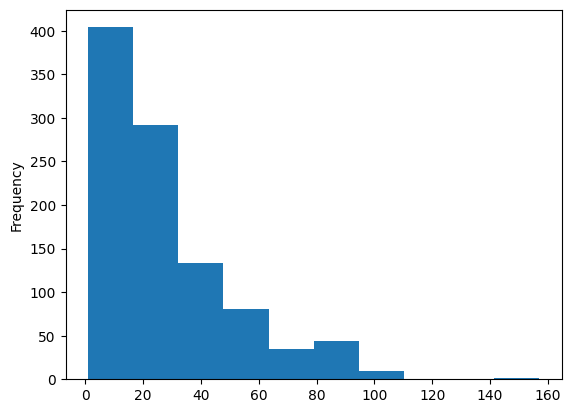

In [48]:
df["review"].str.split(" ").apply(len).plot.hist()

<Axes: >

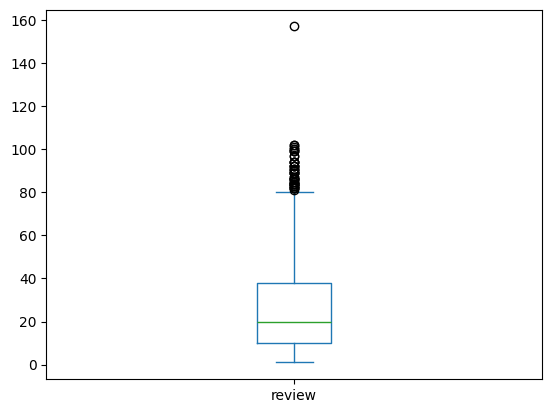

In [49]:
df["review"].str.split().apply(len).plot.box()

In [51]:
df = df[df["review"].str.split().apply(len) < 80].copy(deep=True)
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
994,I like the app but while making the payment it...,negative
995,Songs are great but after a while the audio st...,negative
996,It's a great app but you can't listen to one s...,negative
997,Uh Where's the button to play songs when addin...,negative


<Axes: ylabel='Frequency'>

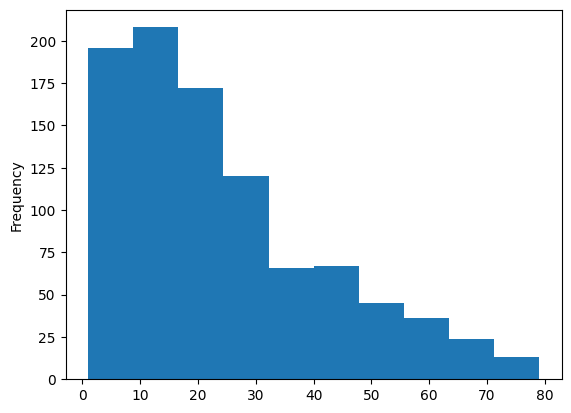

In [52]:
df["review"].str.split(" ").apply(len).plot.hist()

<Axes: >

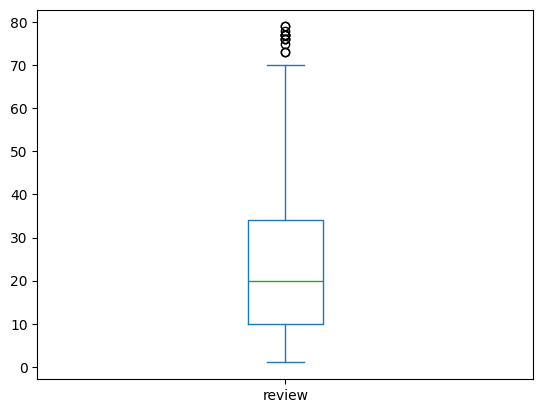

In [53]:
df["review"].str.split().apply(len).plot.box()

In [58]:
df = df[df["review"].str.split().apply(len) < 60].copy(deep=True)
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
4,Best music app so far,positive
5,It was nice before you uploaded the old mood w...,positive
...,...,...
994,I like the app but while making the payment it...,negative
995,Songs are great but after a while the audio st...,negative
996,It's a great app but you can't listen to one s...,negative
997,Uh Where's the button to play songs when addin...,negative


<Axes: >

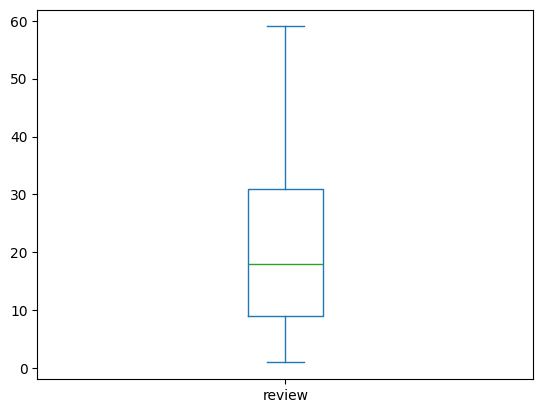

In [59]:
df["review"].str.split().apply(len).plot.box()

<Axes: ylabel='Frequency'>

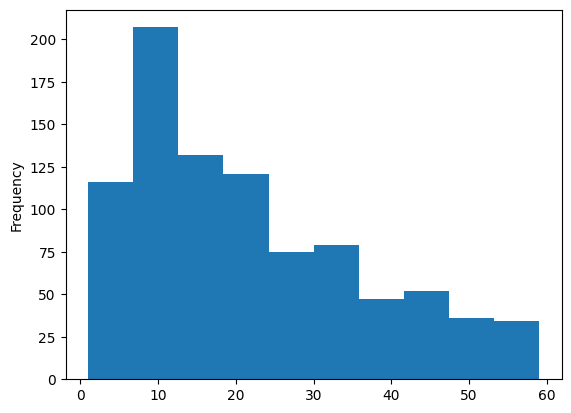

In [61]:
df["review"].str.split(" ").apply(len).plot.hist()

In [62]:

def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [63]:
vocabulary = get_vocabulary(df["review"].tolist())

In [64]:
len(vocabulary)

3615

In [66]:
max_vocabulary_size = 3500

In [67]:
X, y = df["review"], pd.get_dummies(df["label"])

In [69]:
num_classes = y.shape[1]
num_classes

2

In [70]:

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [71]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

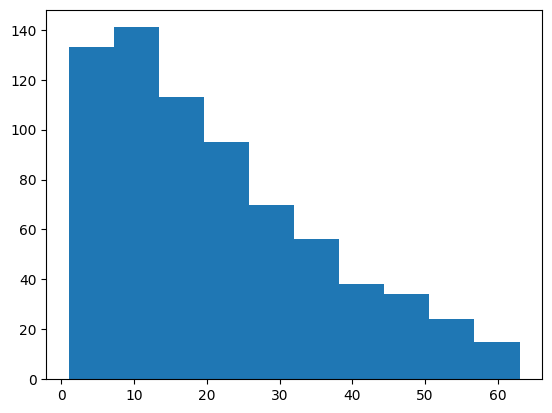

In [72]:
plt.hist([len(tokens) for tokens in train_X]);

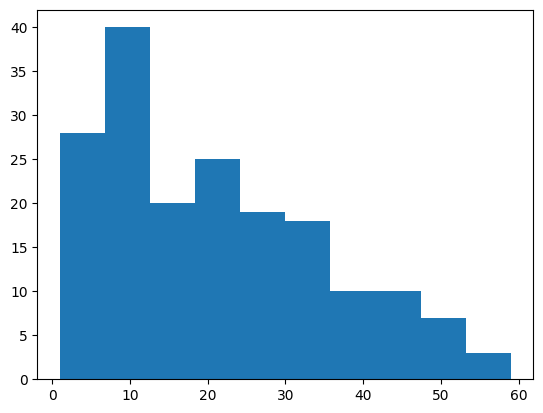

In [73]:
plt.hist([len(tokens) for tokens in test_X]);

In [74]:
maxlen = 40

In [75]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [77]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="sigmoid")
])

In [78]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [79]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=8)

Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - f1_score: 0.4495 - loss: 0.6900 - precision: 0.5553 - recall: 0.4098 - val_f1_score: 0.3484 - val_loss: 0.6791 - val_precision: 0.5347 - val_recall: 0.5347
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - f1_score: 0.3624 - loss: 0.6613 - precision: 0.5688 - recall: 0.5690 - val_f1_score: 0.3484 - val_loss: 0.6669 - val_precision: 0.5379 - val_recall: 0.5417
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score: 0.5420 - loss: 0.6416 - precision: 0.6356 - recall: 0.6569 - val_f1_score: 0.6237 - val_loss: 0.6355 - val_precision: 0.6474 - val_recall: 0.7014
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - f1_score: 0.6281 - loss: 0.6035 - precision: 0.6597 - recall: 0.6874 - val_f1_score: 0.6536 - val_loss: 0.6146 - val_precision: 0.6644 - val_recall: 0.6875
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - f1_score: 0.6897 - loss: 0.5711 - precision: 0.6971 - recall: 0.7244 - val_f1_score: 0.6690 - val_loss: 0.5666 - val_precision

In [80]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 40, 32)              │         112,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 40, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 20, 16)              │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 417,176 (1.59 MB)

 Trainable params: 139,058 (543.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 278,118 (1.06 MB)

<Axes: >

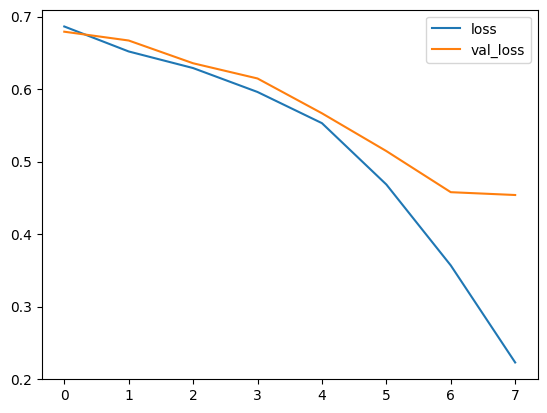

In [81]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [82]:
preds = model.predict(test_X)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [83]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [84]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76        90
           1       0.74      0.88      0.80        90

    accuracy                           0.78       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.79      0.78      0.78       180



Text(0.5, 1.0, 'Confusion Matrix')

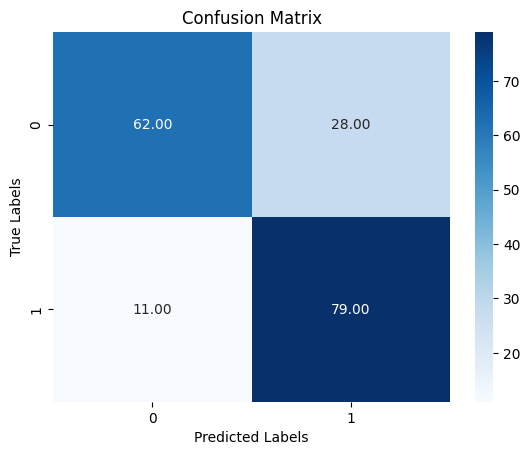

In [85]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")